In [1]:
import os
import cv2
import shutil
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.preprocessing.image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Conv2D, MaxPool2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
#from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from sklearn.preprocessing import LabelEncoder

In [2]:
dataset_path = "tensorflow/dataset"
os.listdir(dataset_path)

['drowsy', 'nondrowsy']

In [3]:
print('drowsy  :',len(os.listdir("tensorflow/dataset/drowsy")))
print('nondrowsy :',len(os.listdir("tensorflow/dataset/nondrowsy")))

drowsy  : 250
nondrowsy : 250


In [4]:
# Load the dataset
data = []
labels = []

# Iterate through the dataset path and load the images
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (150, 150))
        data.append(image)
        labels.append(category)

# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

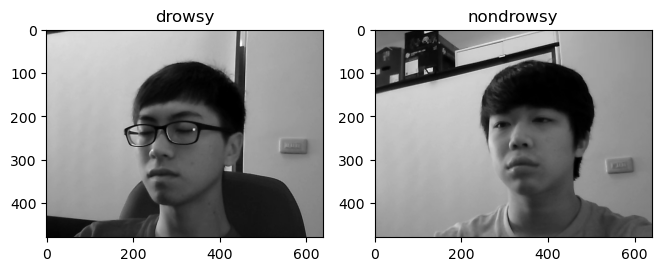

In [5]:
# Perform label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)


# Get a list of images in each grade folder
grade1_images = os.listdir(os.path.join(dataset_path, "drowsy"))
grade2_images = os.listdir(os.path.join(dataset_path, "nondrowsy"))

# Choose a random sample from each grade
sample_grade1 = random.choice(grade1_images)
sample_grade2 = random.choice(grade2_images)

# Load and display the sample images
sample1_path = os.path.join(dataset_path, "drowsy", sample_grade1)
sample2_path = os.path.join(dataset_path, "nondrowsy", sample_grade2)

sample1_img = cv2.imread(sample1_path)
sample2_img = cv2.imread(sample2_path)

# Convert BGR to RGB
sample1_img = cv2.cvtColor(sample1_img, cv2.COLOR_BGR2RGB)
sample2_img = cv2.cvtColor(sample2_img, cv2.COLOR_BGR2RGB)

# Plot the images
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(sample1_img)
plt.title("drowsy")

plt.subplot(1, 3, 2)
plt.imshow(sample2_img)
plt.title("nondrowsy")

plt.tight_layout()
plt.show()


In [6]:
class_names = label_encoder.classes_

In [7]:
# Display the class names
print("Class Names:", class_names)

Class Names: ['drowsy' 'nondrowsy']


In [8]:
# Perform data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation
    width_shift_range=0.1,  # Random horizontal shift
    height_shift_range=0.1,  # Random vertical shift
    shear_range=0.1,  # Shear transformation
    zoom_range=0.1,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    validation_split=0.1  # Splitting the dataset into train and validation sets
)

In [9]:
# Perform label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [10]:
# Split the dataset into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    data, labels, test_size=0.4, stratify=labels, random_state=42
)

In [11]:
# Apply data augmentation to the training set
train_generator = datagen.flow(train_data, train_labels, batch_size=32, subset='training')

# Apply data augmentation to the validation set
val_generator = datagen.flow(val_data, val_labels, batch_size=32, subset='validation')

In [12]:
# Split the validation set into validation and test sets
val_data, test_data, val_labels, test_labels = train_test_split(
    val_data, val_labels, test_size=0.38, stratify=val_labels, random_state=42
)

# Verify again
print(f"test_data: {test_data.shape}, test_labels: {test_labels.shape}")

test_data: (76, 150, 150, 3), test_labels: (76,)


In [13]:
# Get the class names
class_names = label_encoder.classes_

# Display the class names
print("Class Names:", class_names)

Class Names: [0 1]


In [14]:
# Normalize the image data
train_data = train_data.astype('float32') / 255.0
val_data = val_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

# Print the shape of each dataset
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (300, 150, 150, 3)
Validation data shape: (124, 150, 150, 3)
Test data shape: (76, 150, 150, 3)
Train labels shape: (300,)
Validation labels shape: (124,)
Test labels shape: (76,)


In [15]:
print('Train :', len(train_data))
print('Validation :', len(val_data))
print('Test :', len(test_data))

Train : 300
Validation : 124
Test : 76


In [16]:
from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model without the top classifier
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the base model
mobilenet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(4, activation='relu'),
    Dropout(0.3),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
mobilenet_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\Tobias\AppData\Local\Temp\ipykernel_3600\1533665848.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


In [17]:
mobilenet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              15 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,123 (8.63 MB)

 Trainable params: 5,139 (20.07 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
# Train the model
history_v2 = mobilenet_model.fit(train_data, train_labels,
                    epochs=10,
                    batch_size=14,
                    validation_data=(val_data, val_labels))

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - accuracy: 0.4737 - loss: 1.2091 - val_accuracy: 0.6532 - val_loss: 0.9740
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.5992 - loss: 1.0312 - val_accuracy: 0.7742 - val_loss: 0.8525
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.6104 - loss: 1.0005 - val_accuracy: 0.8871 - val_loss: 0.7967
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.6275 - loss: 0.9351 - val_accuracy: 0.8629 - val_loss: 0.7102
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.6677 - loss: 0.8659 - val_accuracy: 0.8387 - val_loss: 0.7840
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.6120 - loss: 0.9212 - val_accuracy: 0.8952 - val_loss: 0.6547
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.6669 - loss: 0.8576 - val_accuracy: 0.9194 - val_loss: 0.6562
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.5981 - loss: 0.9198 - val_accuracy: 0.8710 -

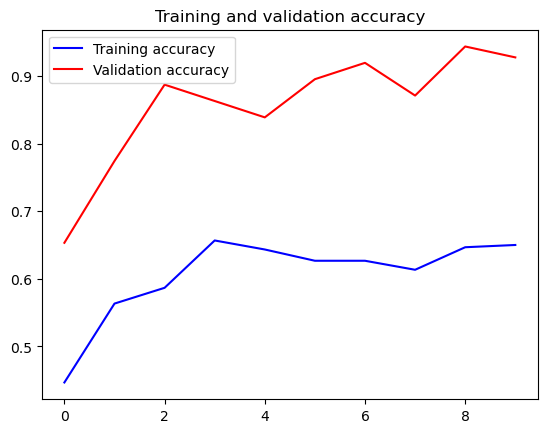

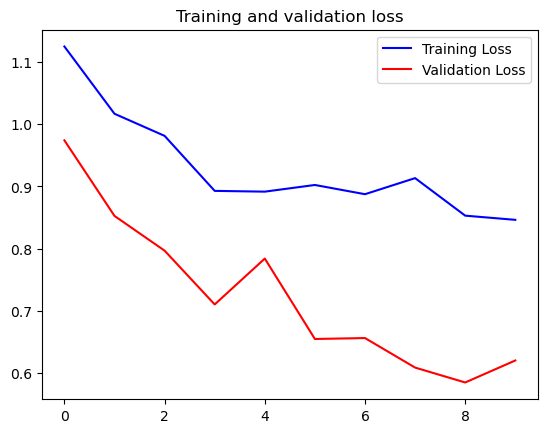

In [19]:
import matplotlib.pyplot as plt

acc = history_v2.history['accuracy']
val_acc = history_v2.history['val_accuracy']
loss = history_v2.history['loss']
val_loss = history_v2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = mobilenet_model.evaluate(test_data, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Get the train accuracy
train_loss, train_accuracy = mobilenet_model.evaluate(train_data, train_labels)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

# Get the val accuracy
val_loss, val_accuracy = mobilenet_model.evaluate(val_data, val_labels)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8861 - loss: 0.6343
Test Loss: 0.6476651430130005
Test Accuracy: 0.8815789222717285
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9847 - loss: 0.5956
Train Loss: 0.6017189025878906
Train Accuracy: 0.9800000190734863
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9231 - loss: 0.6167
Val Loss: 0.6201140880584717
Val Accuracy: 0.9274193644523621


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 845ms/step


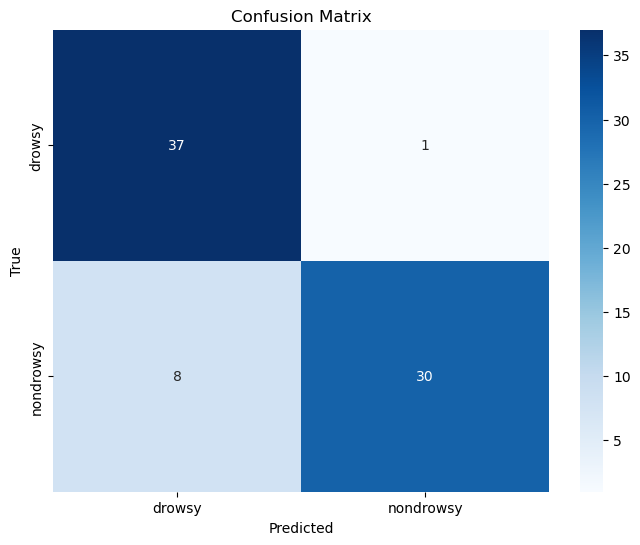

Classification Report:
              precision    recall  f1-score   support

      drowsy       0.82      0.97      0.89        38
   nondrowsy       0.97      0.79      0.87        38

    accuracy                           0.88        76
   macro avg       0.89      0.88      0.88        76
weighted avg       0.89      0.88      0.88        76



In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Get predictions
y_pred = mobilenet_model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_labels

# Make sure class_names is proper strings
class_names = ['drowsy', 'nondrowsy']  # Replace with your actual class names

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

In [22]:
mobilenet_model.save('mobilenet_model.h5')